In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from preprocess.BaselinePrerocess import baseline_process
from baselines.tcn import TCN

2023-08-18 15:25:43.873548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 15:25:46.831616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Parameters

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9


# ===== model parameters ======
nb_filters = 64
kernel_size = 2
dropout = 0.1
dense_units1 = 32
dense_units2 = 32
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 300
EPOCHS = 3000
BATCH = 512

### Preprocess

In [5]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [11]:
inputs = Input(shape=(train_X_mask.shape[1], train_X_mask.shape[2]))
masked_inputs = Masking(mask_value=masked_value)(inputs)

tcn = TCN(nb_filters=nb_filters,
          kernel_size=kernel_size,
          use_batch_norm=False,
          use_weight_norm=False,
          use_layer_norm=True,
          return_sequences=True,
          dropout_rate=dropout,
          activation='relu', 
          input_shape=(train_X_mask.shape[1], train_X_mask.shape[2])
         )(masked_inputs)
x = Dense(32)(tcn)
x = Dropout(dropout)(x)
x = Flatten()(x)
outputs = Dense(96)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

2023-08-10 22:14:54.927642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 16)]          0         
                                                                 
 masking (Masking)           (None, 96, 16)            0         
                                                                 
 tcn (TCN)                   (None, 96, 64)            95552     
                                                                 
 dense (Dense)               (None, 96, 32)            2080      
                                                                 
 dropout (Dropout)           (None, 96, 32)            0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 96)                295008

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../saved_models/WaLeF_tcn.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'TCN': TCN},
                     save_best_only=True
                    )


model.fit(train_X_mask, train_ws_y,
          validation_data=(test_X_mask, test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-08-10 22:15:32.236819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-10 22:15:33.356540: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fde84044140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-10 22:15:33.356593: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-10 22:15:33.365402: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-10 22:15:33.704425: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.20255, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 31s - loss: 1.3863 - mae: 0.7688 - val_loss: 0.0655 - val_mae: 0.2025 - 31s/epoch - 207ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.20255 to 0.15977, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 0.1803 - mae: 0.3339 - val_loss: 0.0402 - val_mae: 0.1598 - 14s/epoch - 94ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.15977 to 0.13860, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 0.1112 - mae: 0.2629 - val_loss: 0.0302 - val_mae: 0.1386 - 14s/epoch - 93ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.13860 to 0.12762, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 0.0797 - mae: 0.2226 - val_loss: 0.0254 - val_mae: 0.1276 - 14s/epoch - 94ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.12762 to 0.11858, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 0.0611 - mae: 0.1949 - val_loss: 0.0219 - val_mae: 0.1186 - 14s/epoch - 94ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.11858 to 0.11475, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 0.0485 - mae: 0.1737 - va


Epoch 40: val_mae improved from 0.03579 to 0.03487, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0019 - val_mae: 0.0349 - 14s/epoch - 95ms/step
Epoch 41/3000

Epoch 41: val_mae improved from 0.03487 to 0.03452, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0019 - val_mae: 0.0345 - 14s/epoch - 95ms/step
Epoch 42/3000

Epoch 42: val_mae improved from 0.03452 to 0.03422, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 15s - loss: 0.0011 - mae: 0.0253 - val_loss: 0.0019 - val_mae: 0.0342 - 15s/epoch - 96ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.03422 to 0.03359, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 0.0011 - mae: 0.0246 - val_loss: 0.0018 - val_mae: 0.0336 - 14s/epoch - 96ms/step
Epoch 44/3000

Epoch 44: val_mae improved from 0.03359 to 0.03350, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 0.0010 - mae: 0.

Epoch 81/3000

Epoch 81: val_mae improved from 0.02664 to 0.02626, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 2.8082e-04 - mae: 0.0118 - val_loss: 0.0011 - val_mae: 0.0263 - 14s/epoch - 95ms/step
Epoch 82/3000

Epoch 82: val_mae improved from 0.02626 to 0.02614, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 2.7711e-04 - mae: 0.0117 - val_loss: 0.0011 - val_mae: 0.0261 - 14s/epoch - 95ms/step
Epoch 83/3000

Epoch 83: val_mae did not improve from 0.02614
151/151 - 14s - loss: 2.6961e-04 - mae: 0.0115 - val_loss: 0.0011 - val_mae: 0.0264 - 14s/epoch - 94ms/step
Epoch 84/3000

Epoch 84: val_mae improved from 0.02614 to 0.02597, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 2.6173e-04 - mae: 0.0113 - val_loss: 0.0011 - val_mae: 0.0260 - 14s/epoch - 95ms/step
Epoch 85/3000

Epoch 85: val_mae improved from 0.02597 to 0.02543, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 2.5605e-04 - mae: 0.0112 - val_loss:

Epoch 120/3000

Epoch 120: val_mae did not improve from 0.01716
151/151 - 14s - loss: 1.3556e-04 - mae: 0.0078 - val_loss: 5.6677e-04 - val_mae: 0.0177 - 14s/epoch - 94ms/step
Epoch 121/3000

Epoch 121: val_mae did not improve from 0.01716
151/151 - 14s - loss: 1.3345e-04 - mae: 0.0077 - val_loss: 5.2356e-04 - val_mae: 0.0172 - 14s/epoch - 94ms/step
Epoch 122/3000

Epoch 122: val_mae did not improve from 0.01716
151/151 - 14s - loss: 1.3213e-04 - mae: 0.0076 - val_loss: 5.5463e-04 - val_mae: 0.0177 - 14s/epoch - 94ms/step
Epoch 123/3000

Epoch 123: val_mae did not improve from 0.01716
151/151 - 14s - loss: 1.3026e-04 - mae: 0.0076 - val_loss: 5.5085e-04 - val_mae: 0.0176 - 14s/epoch - 94ms/step
Epoch 124/3000

Epoch 124: val_mae improved from 0.01716 to 0.01700, saving model to ../saved_models/WaLeF_tcn.h5
151/151 - 14s - loss: 1.2855e-04 - mae: 0.0075 - val_loss: 5.1761e-04 - val_mae: 0.0170 - 14s/epoch - 95ms/step
Epoch 125/3000

Epoch 125: val_mae improved from 0.01700 to 0.01671, s

Epoch 165/3000

Epoch 165: val_mae did not improve from 0.01511
151/151 - 14s - loss: 9.6077e-05 - mae: 0.0063 - val_loss: 4.1990e-04 - val_mae: 0.0153 - 14s/epoch - 94ms/step
Epoch 166/3000

Epoch 166: val_mae did not improve from 0.01511
151/151 - 14s - loss: 9.4860e-05 - mae: 0.0063 - val_loss: 4.3265e-04 - val_mae: 0.0154 - 14s/epoch - 94ms/step
Epoch 167/3000

Epoch 167: val_mae did not improve from 0.01511
151/151 - 14s - loss: 9.4142e-05 - mae: 0.0063 - val_loss: 4.4455e-04 - val_mae: 0.0155 - 14s/epoch - 94ms/step
Epoch 168/3000

Epoch 168: val_mae did not improve from 0.01511
151/151 - 14s - loss: 9.4148e-05 - mae: 0.0063 - val_loss: 4.3531e-04 - val_mae: 0.0154 - 14s/epoch - 94ms/step
Epoch 169/3000

Epoch 169: val_mae did not improve from 0.01511
151/151 - 14s - loss: 9.3190e-05 - mae: 0.0062 - val_loss: 4.5105e-04 - val_mae: 0.0158 - 14s/epoch - 94ms/step
Epoch 170/3000

Epoch 170: val_mae did not improve from 0.01511
151/151 - 14s - loss: 9.3434e-05 - mae: 0.0063 - val_los

Epoch 211/3000

Epoch 211: val_mae did not improve from 0.01451
151/151 - 14s - loss: 8.1122e-05 - mae: 0.0059 - val_loss: 4.5817e-04 - val_mae: 0.0156 - 14s/epoch - 94ms/step
Epoch 212/3000

Epoch 212: val_mae did not improve from 0.01451
151/151 - 14s - loss: 8.1755e-05 - mae: 0.0059 - val_loss: 4.4792e-04 - val_mae: 0.0155 - 14s/epoch - 94ms/step
Epoch 213/3000

Epoch 213: val_mae did not improve from 0.01451
151/151 - 14s - loss: 8.0605e-05 - mae: 0.0058 - val_loss: 4.1198e-04 - val_mae: 0.0149 - 14s/epoch - 94ms/step
Epoch 214/3000

Epoch 214: val_mae did not improve from 0.01451
151/151 - 14s - loss: 8.0618e-05 - mae: 0.0058 - val_loss: 4.5251e-04 - val_mae: 0.0155 - 14s/epoch - 94ms/step
Epoch 215/3000

Epoch 215: val_mae did not improve from 0.01451
151/151 - 14s - loss: 8.0098e-05 - mae: 0.0058 - val_loss: 4.2635e-04 - val_mae: 0.0152 - 14s/epoch - 94ms/step
Epoch 216/3000

Epoch 216: val_mae did not improve from 0.01451
151/151 - 14s - loss: 8.0099e-05 - mae: 0.0058 - val_los

Epoch 257/3000

Epoch 257: val_mae did not improve from 0.01448
151/151 - 14s - loss: 7.4928e-05 - mae: 0.0057 - val_loss: 4.5647e-04 - val_mae: 0.0156 - 14s/epoch - 94ms/step
Epoch 258/3000

Epoch 258: val_mae did not improve from 0.01448
151/151 - 14s - loss: 7.4468e-05 - mae: 0.0056 - val_loss: 4.3717e-04 - val_mae: 0.0152 - 14s/epoch - 94ms/step
Epoch 259/3000

Epoch 259: val_mae did not improve from 0.01448
151/151 - 14s - loss: 7.4361e-05 - mae: 0.0056 - val_loss: 4.7617e-04 - val_mae: 0.0159 - 14s/epoch - 93ms/step
Epoch 260/3000

Epoch 260: val_mae did not improve from 0.01448
151/151 - 14s - loss: 7.4783e-05 - mae: 0.0056 - val_loss: 4.3711e-04 - val_mae: 0.0153 - 14s/epoch - 94ms/step
Epoch 261/3000


### Performance

In [17]:
saved_model = load_model('../saved_models/WaLeF_tcn.h5', custom_objects={'TCN': TCN})


yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 4s 5ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0724
RMSE = 0.1051


In [18]:
# inv_yhat = pd.DataFrame(inv_yhat)
# inv_yhat.to_csv('saved_results/tcn_inv_yhat.csv')

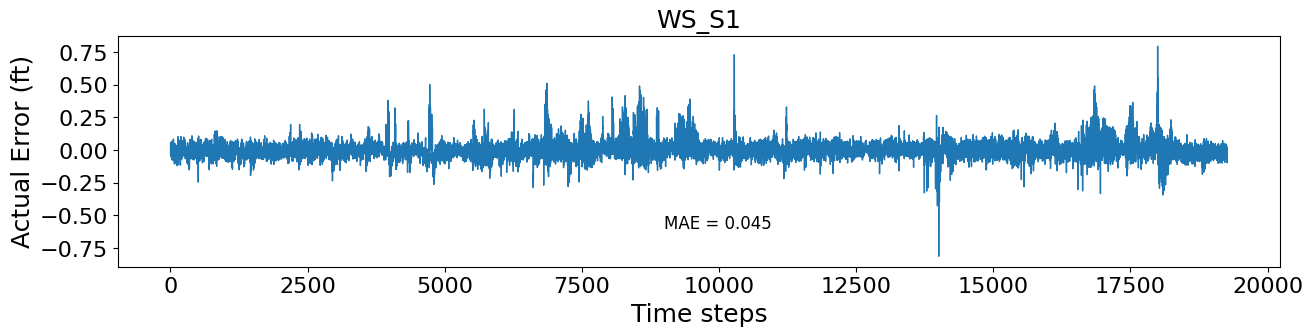

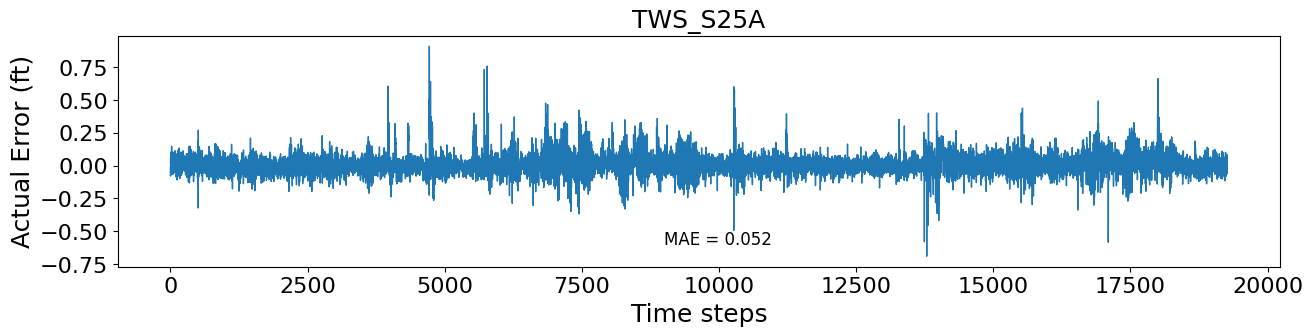

In [ ]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [ ]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

In [ ]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

In [ ]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))